# Library

In [ ]:
pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 54.1 MB/s eta 0:00:00


In [ ]:
#pip install tensorflow-gpu==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.1


In [ ]:
pip install keras

# Data loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

DATA = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/train.csv'
DEV_DATA = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/val.csv'
TEST_DATA = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['Comment']
y_train = train_data['Label'].values

X_dev = dev_data['Comment']
y_dev = dev_data['Label'].values

X_test = test_data['Comment']
y_test = test_data['Label'].values

5665
809
1619


In [ ]:
import pandas as pd
import numpy as np

from pyvi.ViTokenizer import ViTokenizer

STOPWORDS = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

In [ ]:
# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

# Run models

## Text CNN (Convolutional neural network for text classification)

In [ ]:
import keras
print(keras.__version__)

2.12.0


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Text CNN
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [ ]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

EMBEDDING_FILE = '/content/drive/MyDrive/MachineLearning/FinalTerm/TextCNN/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/MachineLearning/FinalTerm/TextCNN/Text_CNN_model_v13.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    #X = sequence.pad_sequences(X, maxlen=sequence_length)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

In [ ]:
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)

In [ ]:
#with open('drive/My Drive/CODE/HSD/tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [ ]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     1357800     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 300, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 99, 1, 32)    19232       ['reshape[0][0]']                
                                                                                              

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


23/23 [==============================] - 14s 51ms/step - loss: 1.0174 - accuracy: 0.5940 - val_loss: 0.9434 - val_accuracy: 0.7417
Epoch 2/40
23/23 [==============================] - 0s 19ms/step - loss: 0.8772 - accuracy: 0.7622 - val_loss: 0.8443 - val_accuracy: 0.7676
Epoch 3/40
23/23 [==============================] - 0s 17ms/step - loss: 0.7900 - accuracy: 0.7935 - val_loss: 0.7707 - val_accuracy: 0.7726
Epoch 4/40
23/23 [==============================] - 0s 17ms/step - loss: 0.7176 - accuracy: 0.8005 - val_loss: 0.7115 - val_accuracy: 0.7763
Epoch 5/40
23/23 [==============================] - 0s 18ms/step - loss: 0.6605 - accuracy: 0.8048 - val_loss: 0.6648 - val_accuracy: 0.7824
Epoch 6/40
23/23 [==============================] - 0s 17ms/step - loss: 0.6170 - accuracy: 0.8125 - val_loss: 0.6259 - val_accuracy: 0.7911
Epoch 7/40
23/23 [==============================] - 0s 18ms/step - loss: 0.5819 - accuracy: 0.8189 - val_loss: 0.5921 - val_accuracy: 0.7948
Epoch 8/40
23/23 [=====

<Axes: >

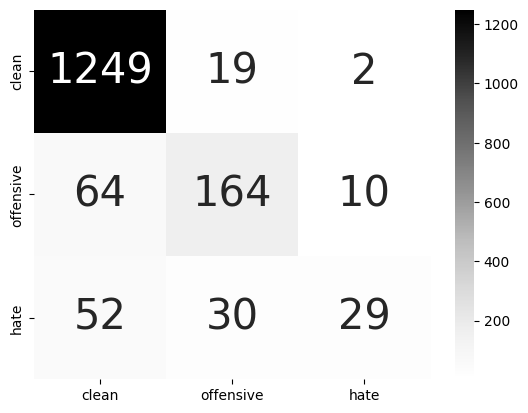

In [ ]:
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

### Testing

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] != test_y[i]:
      print(test_data['Comment'][i], '|',y_pred[i] , '|', test_y[i])

se mấy bữa_nay giả fan trung_lập đi nhục kinh lắm | 0 | 2
bình_luận_viên hơi lạnh phải🤣🤣🤣 | 0 | 2
híu thảo đồ | 0 | 2
who need dev 1 ve: v | 0 | 2
mày đánh lux cặc | 0 | 2
??? huy bú | 1 | 2
đặc cầu | 0 | 1
aduvipwa | 0 | 1
zeus non học 369:)))) | 0 | 2
ys cặc | 1 | 2
2 đội gà v | 0 | 2
bọn như cặc già | 1 | 0
rên đi | 0 | 1
nizy nhon vãi lồn =)) | 1 | 2
mấy hề đánh | 0 | 2
quang hải thịt trih trâu | 0 | 2
cưỡi con_bé awesome | 0 | 2
tưởng caster adu clma | 0 | 1
duma rừng | 0 | 1
sài_gòn lạnh chúng_mày chẳng hiểu sao đá | 0 | 2
red hút đá s | 0 | 2
lồn out trình sea | 1 | 0
đạn, firerate chậm, giật, spam lộ đường_đạn... như cặc cân_bằng. rito said: d | 1 | 0
ngu câm | 2 | 1
moá đánh bắt | 0 | 1
đù 18 | 1 | 0
na hành máy quen =)) | 0 | 2
diana điên | 0 | 2
chết mẹ | 0 | 1
mẹ sp hoài | 0 | 1
lê khánh vô_học | 0 | 2
chấn bé đù | 1 | 2
vcs rác | 0 | 2
ngài điên | 0 | 2
quốc nhục gân đàm | 0 | 1
200 ntr clgt awesome | 0 | 1
ảo đá | 0 | 1
đi rừng ngu nh chó | 2 | 1
trụ rồng, chiến_thuật bọn

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] == test_y[i]:
      print(test_data['Comment'][i], '|',y_pred[i] , '|', test_y[i])

kệ | 0 | 0
nan | 0 | 0
thầy cổ_vũ | 0 | 0
khóc | 0 | 0
palyin thiết_kế kiểu underground đẹp | 0 | 0
am dí awesome | 0 | 0
đá | 0 | 0
win | 0 | 0
3 thằng đương_kim vô_địch | 0 | 0
đi tù đấm | 0 | 0
hạ cung cầm bola | 0 | 0
hài vãi lồn | 1 | 1
skud đẩy ác | 0 | 0
bkb daedalus | 0 | 0
venge? | 0 | 0
ban huấn_luyện vcs hẳn | 0 | 0
all end n | 0 | 0
2 đi | 0 | 0
châu_âu bố:)) | 0 | 0
cóc lông lo awesome | 0 | 0
sấy b51 khiếp vãi lồn | 1 | 1
lai | 0 | 0
kéo | 0 | 0
bom xong bắn line up trông mệt vãi lồn | 1 | 1
h mong quang bẹp áo hq | 0 | 0
2 mid | 0 | 0
medu neft yếu_xìu | 0 | 0
duma admin người ta đánh ác vãi cặc | 1 | 1
team bắt am nổi | 0 | 0
xia throw? eco cay_chua | 0 | 0
2-5 | 0 | 0
dùm | 0 | 0
lồn ngu vãi cặc đéo hbiet gankj | 1 | 1
smoke real | 0 | 0
call tầm_bậy awesome | 0 | 0
đứng wukong chúng_sinh bình_đẳng =)))) | 0 | 0
hề vãi cả lồn, fan fl cay sgp thắng:)) | 1 | 1
bé đần =]] | 2 | 2
bắt faker cắm mắt chim! tỉnh lắm | 0 | 0
4 nô_lệ | 0 | 0
ruler | 0 | 0
10h đêm đỉnh_cao crowd

## GRU (Gated Recurrent Units)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     3000000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 160)     182880      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 24048 samples, validate on 2672 samples
Epoch 1/40
24048/24048 [==============================] - 23s 974us/step - loss: 0.8845 - accuracy: 0.7465 - val_loss: 0.6613 - val_accuracy: 0.8196
Epoch 2/40
24048/24048 [==============================] - 22s 911us/step - loss: 0.5874 - accuracy: 0.8269 - val_loss: 0.5807 - val_accuracy: 0.8196
Epoch 3/40
24048/24048 [==============================] - 22s 907us/step - loss: 0.5430 - accuracy: 0.8269 - val_loss: 0.5475 - val_accuracy: 0.8196
Epoch 4/40
24048/24048 [==============================] - 22s 911us/step - loss: 0.5045 - accuracy: 0.8291 - val_loss: 0.5062 - val_accuracy: 0.8260
Epoch 5/40
24048/24048 [==============================] - 22s 918us/step - loss: 0.4582 - accuracy: 0.8415 - val_loss: 0.4636 - val_accuracy: 0.8383
Epoch 6/40
24048/24048 [==============================] - 22s 906us/step - loss: 0.4130 - accuracy: 0.8552 - val_loss: 0.4347 - val_accuracy: 0.8424
Epoch 7/40
24048/24048 [==============================] -

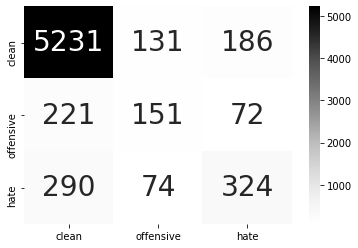

In [ ]:
# GRU
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input, Bidirectional, GRU
from keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from pyvi.ViTokenizer import ViTokenizer

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

EMBEDDING_FILE = 'drive/My Drive/CODE/HSD/embedding/cc.vi.300.vec'
MODEL_FILE = 'drive/My Drive/CODE/HSD/model/GRU_model_v4.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('drive/My Drive/CODE/HSD/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(3, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)
print(cf2)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm2 = pd.DataFrame(cf2, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})